# 라이브러리 로드

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Positional Encoding

In [65]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# scaled dot product attention

In [2]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)
    return output


# MultiHeadAttention

In [3]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)

        return outputs

# Padding mask & Look ahead mask

In [4]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [5]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

# 인코더 정의

In [6]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [7]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 디코더 정의

In [8]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [9]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 데이터셋 정의

In [52]:
data = pd.read_csv("transformer_chatbot/data/ChatbotData .csv")
questions = data["Q"].tolist()
answers = data["A"].tolist()

In [53]:
questions = [word.replace("?", "").replace("!", "").replace(".", "").replace(",", "") for word in questions]
answers = [word.replace("?", "").replace("!", "").replace(".", "").replace(",", "") for word in answers]

In [54]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [55]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [56]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8190]
END_TOKEN의 번호 : [8191]


In [57]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8192


In [58]:
print(questions[22])
print(answers[22])

question_sample = tokenizer.encode(questions[22])
answer_sample = tokenizer.encode(answers[22])
print(f'정수 인코딩 후의 22번째 질문 샘플: {question_sample}')
print(f'정수 인코딩 후의 22번째 답변 샘플: {answer_sample}')

가장 확실한 건 뭘까
가장 확실한 시간은 오늘이에요 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요
정수 인코딩 후의 22번째 질문 샘플: [379, 804, 37, 407]
정수 인코딩 후의 22번째 답변 샘플: [379, 804, 907, 6543, 5090, 7615, 1110, 7806, 341, 5601, 41]


In [59]:
MAX_LENGTH = 10

10


In [60]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [61]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :', VOCAB_SIZE)
print(f'필터링 후의 질문 샘플 개수: {len(questions)}')
print(f'필터링 후의 답변 샘플 개수: {len(answers)}')

단어장의 크기 : 8192
필터링 후의 질문 샘플 개수: 9927
필터링 후의 답변 샘플 개수: 9927


In [62]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 모델 정의 및 훈련

In [83]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [66]:
tf.keras.backend.clear_session()


NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3151360     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [67]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [68]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [69]:
sample_learning_rate = CustomSchedule(d_model=128)

In [70]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [72]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
156/156 [==============================] - 10s 61ms/step - loss: 4.4625 - accuracy: 0.1111
Epoch 2/20
156/156 [==============================] - 10s 61ms/step - loss: 3.9733 - accuracy: 0.1111
Epoch 3/20
156/156 [==============================] - 10s 61ms/step - loss: 3.6904 - accuracy: 0.1142
Epoch 4/20
156/156 [==============================] - 10s 61ms/step - loss: 3.4571 - accuracy: 0.1270
Epoch 5/20
156/156 [==============================] - 10s 62ms/step - loss: 3.2466 - accuracy: 0.1399
Epoch 6/20
156/156 [==============================] - 10s 62ms/step - loss: 3.0302 - accuracy: 0.1578
Epoch 7/20
156/156 [==============================] - 10s 62ms/step - loss: 2.7899 - accuracy: 0.1826
Epoch 8/20
156/156 [==============================] - 10s 62ms/step - loss: 2.5241 - accuracy: 0.2131
Epoch 9/20
156/156 [==============================] - 10s 62ms/step - loss: 2.2388 - accuracy: 0.2452
Epoch 10/20
156/156 [==============================] - 10s 62ms/step - loss: 1.938

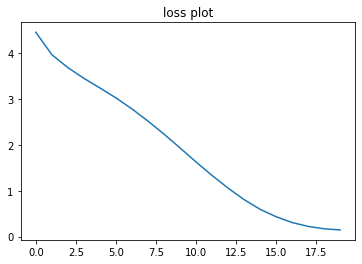

In [98]:
plt.plot(history.history['loss'])
plt.title("loss plot")
plt.show()

# 문장 출력 함수 정의

In [76]:
def preprocess_sentence(sentence):
    sentence = sentence.replace(".", "").replace(",", "").replace("!", "").replace("?", "").strip()
    return sentence

In [77]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [78]:
def sentence_generation(sentence):
    prediction = decoder_inference(sentence)

    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print(f'입력 : {sentence}')
    print(f'출력 : {predicted_sentence}')

    return predicted_sentence

# 챗봇 테스트

In [80]:
sentence_generation('반갑습니다')

입력 : 반갑습니다
출력 : 저도 반가워요


'저도 반가워요'

In [81]:
sentence_generation('오늘 날씨가 안좋아요')

입력 : 오늘 날씨가 안좋아요
출력 : 마음도 추운가요


'마음도 추운가요'

In [82]:
sentence_generation('열심히 공부합시다')

입력 : 열심히 공부합시다
출력 : 그렇게 생각하는 사람 만나지 마세요


'그렇게 생각하는 사람 만나지 마세요'

In [89]:
sentence_generation('여행가고 싶다')

입력 : 여행가고 싶다
출력 : 계획을 세워보세요


'계획을 세워보세요'